In [117]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm

In [118]:
path_estreams = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams'

In [119]:
network_estreams = pd.read_csv(path_estreams+'\streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

network_estreams

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,num_continuous_days,num_days_gaps,num_days_reliable,num_days_noflag,num_days_suspect,gauge_flag,duplicated_suspect,watershed_group,gauges_upstream,nested_catchments
basin_id,,,,,,,,,,,,,,,,,,,,,
AT000001,200014,Bangs,AT,AT_EHYD,Rhein,9.534835,47.273748,9.534835,47.273748,420,...,9497,0.0,0.0,9497.0,0.0,B,['CH000197'],1,16,"['AT000001', 'CH000010', 'CH000046', 'CH000048..."
AT000002,200048,Schruns (Vonbunweg),AT,AT_EHYD,Litz,9.913677,47.080301,9.913677,47.080301,673,...,23103,0.0,0.0,23103.0,0.0,B,['CH000221'],1,1,['AT000002']
AT000003,231662,Loruens-Aeule,AT,AT_EHYD,Ill,9.847765,47.132821,9.847765,47.132821,579,...,13513,0.0,0.0,13513.0,0.0,B,['CH000215'],1,2,"['AT000002', 'AT000003', 'CH000221']"
AT000004,200592,Kloesterle (OEBB),AT,AT_EHYD,Alfenz,10.061843,47.128994,10.061843,47.128994,1014,...,8765,0.0,0.0,8765.0,0.0,B,['CH000227'],1,1,['AT000004']
AT000005,200097,Buers (Bruecke L82),AT,AT_EHYD,Alvier,9.802668,47.150770,9.802668,47.150770,564,...,10957,0.0,0.0,10957.0,0.0,B,['CH000214'],1,3,"['AT000005', 'CH000214']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAGR0017,6682300,BASHTANOVKA,UA,UA_GRDC,KACHA,33.894739,44.691884,33.900000,44.683333,NaN,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1988,1,['UAGR0017']
UAGR0018,6682500,YALTA,UA,UA_GRDC,DERE-KIOY,34.166667,44.500000,34.166667,44.500000,16,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1989,1,['UAGR0018']
UAGR0019,6683010,PIONERSKOE,UA,UA_GRDC,SALHYR,34.199841,44.887685,34.200000,44.883333,307,...,3652,0.0,0.0,3652.0,0.0,B,NaN,1990,1,['UAGR0019']


In [ ]:
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [504]:
#basin_id = "FR000702"
#basin_id = "PL000700"
basin_id = "FR000154"
basin_id = "CH000001"
basin_id = "FR003237" # Epinal
#basin_id = "DERP2004" # GemuendOur
#basin_id = "DERP2007" # Pruemzurlay
basin_id = "DERP2023"
basin_id = "LU000011"
basin_id = "LU000001"
basin_id = "LU000007" #Ettelbruck
basin_id = "LU000015" #Michelau
#basin_id = "DERP2004" 
#basin_id = "FR003237" # Epinal

#basin_id = "PT000102" 

#basin_id = "ITVE0429" 
basin_id = "FR003253" # Luneville



In [511]:
data = pd.read_csv(r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Data\data"+"\estreams_timeseries_"+basin_id+".csv", index_col=0)

In [512]:
network_estreams.loc[basin_id, :]

gauge_id                                                      A634101001
gauge_name                                      La Meurthe Ã  LunÃ©ville
gauge_country                                                         FR
gauge_provider                                              FR_EAUFRANCE
river                                             La Meurthe à Lunéville
lon_snap                                                        6.481033
lat_snap                                                       48.582851
lon                                                             6.481033
lat                                                            48.582851
elevation                                                            219
area_official                                                     1105.0
area_estreams                                                    1102.95
area_flag                                                              0
area_rel                                           

In [513]:
area = network_estreams.loc[basin_id, "area_estreams"]
area

1102.95

In [514]:
data["Q"] = data.loc[:, "q_mean"]
data["Q"] = (data.Q * 86400 * 1000) / (area * 1000000)
data

,p_mean,t_mean,t_min,t_max,sp_mean,rh_mean,ws_mean,swr_mean,pet_mean,q_mean,Q
date,,,,,,,,,,,
1950-01-01,0.00,-3.76,-6.91,-0.32,1028.62,78.57,NaN,56.12,0.29,NaN,NaN
1950-01-02,9.09,-1.85,-7.85,2.63,1026.90,76.47,NaN,33.32,0.42,NaN,NaN
1950-01-03,5.31,0.89,-0.05,2.37,1014.76,NaN,NaN,13.00,0.23,NaN,NaN
1950-01-04,8.16,1.81,-0.53,3.58,1008.47,NaN,NaN,15.22,0.33,NaN,NaN
1950-01-05,7.43,3.97,0.92,6.09,1007.31,89.01,NaN,14.44,0.41,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,0.00,21.55,15.85,27.91,1017.25,55.03,2.96,326.22,5.35,4.53,0.354859
2023-06-27,0.00,18.07,14.60,22.77,1020.48,54.98,2.44,273.56,4.00,4.60,0.360343
2023-06-28,0.00,19.14,13.68,24.98,1017.92,57.81,1.75,243.80,4.85,4.86,0.380710


In [515]:
#data = data.loc["1988":"2001", :]
data = data.loc["2002":"2015"]

data

,p_mean,t_mean,t_min,t_max,sp_mean,rh_mean,ws_mean,swr_mean,pet_mean,q_mean,Q
date,,,,,,,,,,,
2002-01-01,0.00,-6.30,-10.64,-1.70,1040.30,87.47,0.91,45.49,0.27,73.2,5.734149
2002-01-02,0.00,-5.02,-10.49,-0.27,1035.95,85.66,0.68,65.78,0.33,54.4,4.261444
2002-01-03,0.00,-5.20,-9.23,-0.85,1030.88,80.64,1.89,61.57,0.29,46.8,3.666095
2002-01-04,0.00,-7.17,-12.16,-2.62,1035.82,81.24,0.78,50.61,0.27,41.8,3.274419
2002-01-05,0.00,-5.94,-10.31,-1.83,1039.91,85.88,0.32,59.94,0.28,37.8,2.961077
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,12.96,0.24,-1.57,2.09,1001.47,93.60,4.87,13.44,0.27,20.8,1.629376
2014-12-28,0.00,-5.75,-8.24,-3.21,1021.12,88.14,3.29,32.65,0.21,25.6,2.005386
2014-12-29,2.93,-7.74,-12.43,-2.94,1036.90,91.61,1.43,19.89,0.24,20.7,1.621542


<Axes: xlabel='date'>

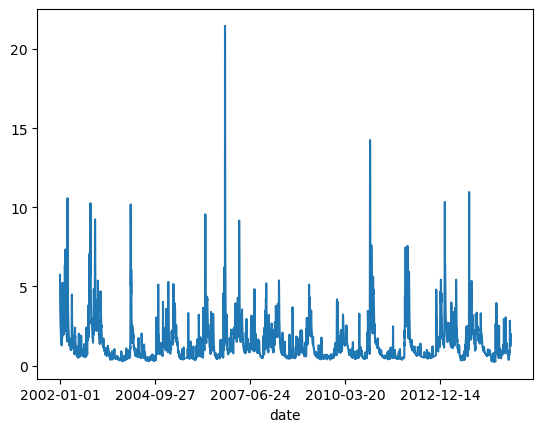

In [516]:
data.Q.plot()

In [517]:
data.Q.isnull().values.any()

True

In [518]:
data.p_mean.isnull().values.any()

False

In [519]:
data['pet_mean'] = data['pet_mean'].interpolate()
data.pet_mean.isnull().values.any()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_22448\2048656765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pet_mean'] = data['pet_mean'].interpolate()


False

<Axes: xlabel='date'>

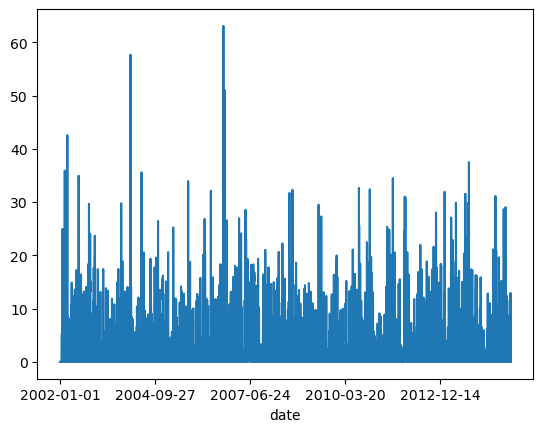

In [520]:
data.loc[:, "p_mean"].plot()

<Axes: xlabel='date'>

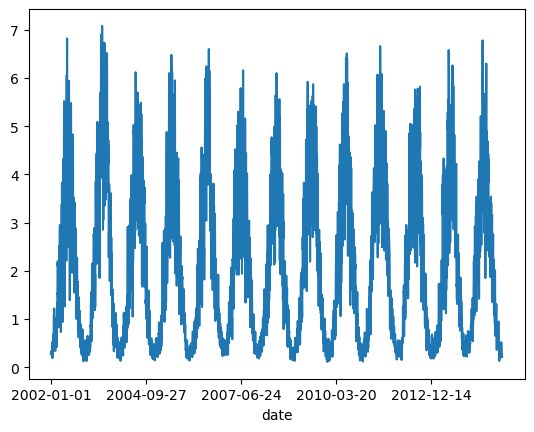

In [521]:
data.loc[:, "pet_mean"].plot()

<Axes: xlabel='date'>

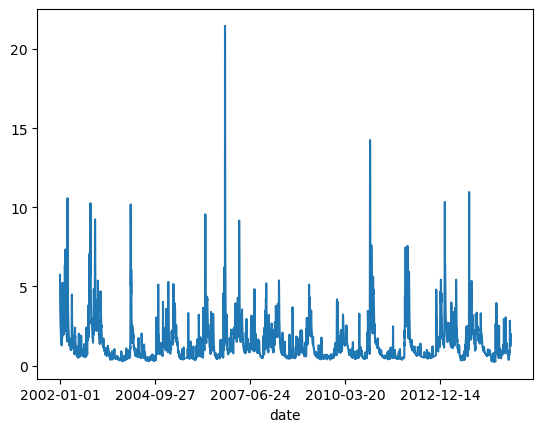

In [522]:
data.loc[:, "Q"].plot()

In [523]:
Q_obs = data.loc[:, "Q"].values
Q_obs

array([5.73414933, 4.26144431, 3.66609547, ..., 1.62154223, 1.37870257,
       1.27686659])

In [524]:
P = data.loc[:, "p_mean"].values
P

array([0.  , 0.  , 0.  , ..., 2.93, 0.  , 0.  ])

In [525]:
E = data.loc[:, "pet_mean"].values
E

array([0.27, 0.33, 0.29, ..., 0.24, 0.23, 0.22])

In [526]:
T = data.loc[:, "t_mean"].values
T

array([-6.3 , -5.02, -5.2 , ..., -7.74, -2.8 , -1.17])

#### Calibration:

In [527]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

#root_finder = PegasusPython()
#num_app = ImplicitEulerPython(root_finder=root_finder)

root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'split-par']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter2 = ParameterizedSingleFluxSplitter(
    parameters={'split-par': 0.6},
    id='lowersplitter'
)

unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 50.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

hyd_mod = Unit(
    layers=[
        [unsaturated],
        [lower_splitter2],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='M4'
)

hyd_mod

Module: superflexPy
Unit: M4
Layers:
	[['unsaturated'], ['lowersplitter'], ['slow', 'lag-fun'], ['lower-transparent', 'fast'], ['lower-junction']]
********************
Module: superflexPy
Element: unsaturated
Parameters:
	M4_unsaturated_Smax : 50.0
	M4_unsaturated_Ce : 1.0
	M4_unsaturated_m : 0.01
	M4_unsaturated_beta : 2.0
States:
	M4_unsaturated_S0 : 10.0

********************
Module: superflexPy
Element: lowersplitter
Parameters:
	M4_lowersplitter_split-par : 0.6

********************
Module: superflexPy
Element: slow
Parameters:
	M4_slow_k : 0.0001
	M4_slow_alpha : 1.0
States:
	M4_slow_S0 : 0.0

********************
Module: superflexPy
Element: lag-fun
Parameters:
	M4_lag-fun_lag-time : 4.0
States:
	M4_lag-fun_lag : None

********************
Module: superflexPy
Element: lower-transparent

********************
Module: superflexPy
Element: fast
Parameters:
	M4_fast_k : 0.01
	M4_fast_alpha : 2.0
States:
	M4_fast_S0 : 0.0

********************
Module: superflexPy
Element: lower-juncti

In [315]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):
        #obj_fun = spotpy.objectivefunctions.rmse(evaluation=evaluation,
        #                                                  simulation=simulation)
        #obj_fun = np.sum(np.sqrt(((simulation - evaluation)**2)/100))
        #obj_fun = obj_fun_nsee(observations = evaluation, simulation = simulation, expo = 0.5)
        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        #obj_fun = obj_fun_kge(observations = evaluation_used, simulation = simulation_used)

        
        return obj_fun

In [316]:
print(hyd_mod)

Module: superflexPy
Unit: M4
Layers:
	[['unsaturated'], ['lowersplitter'], ['slow', 'lag-fun'], ['lower-transparent', 'fast'], ['lower-junction']]
********************
Module: superflexPy
Element: unsaturated
Parameters:
	M4_unsaturated_Smax : 50.0
	M4_unsaturated_Ce : 1.3417019938312331
	M4_unsaturated_m : 0.6970495280933787
	M4_unsaturated_beta : 3.3080490674028042
States:
	M4_unsaturated_S0 : 47.377469777933904

********************
Module: superflexPy
Element: lowersplitter
Parameters:
	M4_lowersplitter_split-par : 0.7289811945039018

********************
Module: superflexPy
Element: slow
Parameters:
	M4_slow_k : 0.002147147508783811
	M4_slow_alpha : 1.0
States:
	M4_slow_S0 : 545.9623551590967

********************
Module: superflexPy
Element: lag-fun
Parameters:
	M4_lag-fun_lag-time : 1.193313178731651
States:
	M4_lag-fun_lag : [array([0., 0.])]

********************
Module: superflexPy
Element: lower-transparent

********************
Module: superflexPy
Element: fast
Parameters:


In [317]:
hyd_mod.get_states()

{'M4_unsaturated_S0': 47.377469777933904,
 'M4_slow_S0': 545.9623551590967,
 'M4_lag-fun_lag': [array([0., 0.])],
 'M4_fast_S0': 1.118921579022887}

In [318]:
spotpy_hyd_mod = spotpy_model(
    model=hyd_mod,
    inputs=[P, E],
    dt=1.0,
    observations = Q_obs,
    parameters=[
        spotpy.parameter.Uniform('M4_fast_k', 1e-5, 1.0), #1e-3, 0.5
        #spotpy.parameter.Uniform('M4_fast_alpha', 1.0, 2.0),
        spotpy.parameter.Uniform('M4_slow_k ', 1e-8, 0.1), #0.0001, 1.0
        #spotpy.parameter.Uniform('M4_slow_alpha ', 1, 2),
        #spotpy.parameter.Uniform('M4_unsaturated_Smax', 50, 600), #
        
        spotpy.parameter.Uniform('M4_unsaturated_Ce', 0.1, 3.0),#0.5, 4.0
        spotpy.parameter.Uniform('M4_unsaturated_m', 0.01, 1.0),
        spotpy.parameter.Uniform('M4_unsaturated_beta', 0.1, 10.0),#1.0, 4.0
        spotpy.parameter.Uniform('M4_lowersplitter_split-par', 0.5, 0.9),
        spotpy.parameter.Uniform('M4_lag-fun_lag-time', 1.0, 4.0),
        
    ],
    #parameter_names=['model_FR1_k', 'model_FR1_alpha', 'model_FR1_Ce'],
    parameter_names=['M4_fast_k', 'M4_slow_k', 'M4_unsaturated_Ce', 'M4_unsaturated_m', 'M4_unsaturated_beta',
                     'M4_lowersplitter_split-par', 'M4_lag-fun_lag-time'],
    output_index=0
)

In [ ]:
hyd_mod.reset_states()
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler.sample(repetitions=5000)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
42 of 100, minimal objective function=0.178189, time remaining: 00:00:03
86 of 100, minimal objective function=0.178189, time remaining: 00:00:01
Stopping samplig. Maximum number of repetitions reached already during burn-in
Burn-in sampling completed...
*** OPTIMIZATION SEARCH TERMINATED BECAUSE THE LIMIT
ON THE MAXIMUM NUMBER OF TRIALS 
100
HAS BEEN EXCEEDED.  SEARCH WAS STOPPED AT TRIAL NUMBER:
100
OF THE INITIAL LOOP!
Starting Complex Evolution...
SEARCH WAS STOPPED AT TRIAL NUMBER: 100
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.995114
THE BEST POINT HAS IMPROVED IN LAST 100 LOOPS BY 100000.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 4.69 seconds
Total Repetitions: 100
Minimal objective value: 0.178189
Corresponding para

The figure as been saved as "Parameter_trace.png


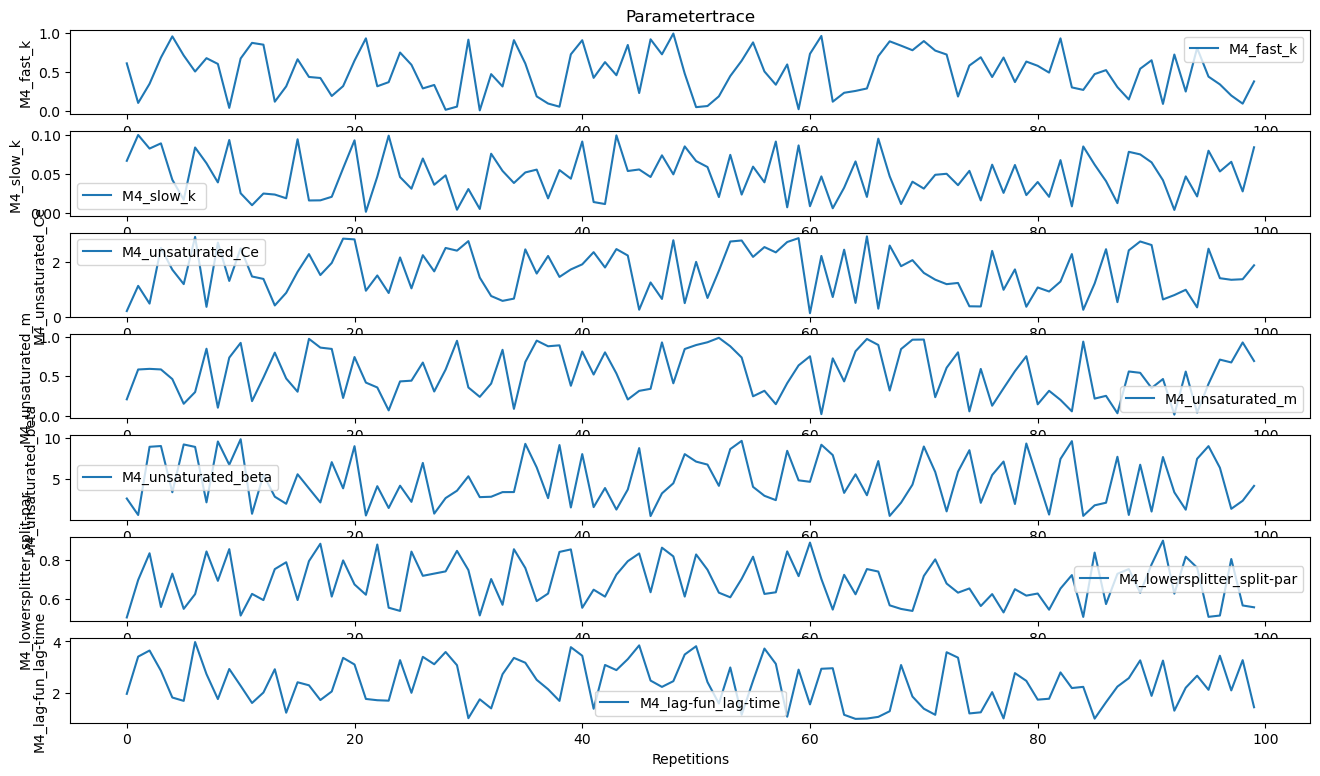

In [320]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results

In [321]:
bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function

spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')

# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}


best_model_run = results[bestindex]                                           # Get the outputs from the best run
best_model_run


fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])

Run number 37 has the lowest objectivefunction with: 0.1782


In [322]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = best_simulation[365:], expo = 0.5)

0.8218222163171827

In [323]:
1 - obj_fun_kge(observations = Q_obs[365:], simulation = best_simulation[365:])

0.6287776001108286

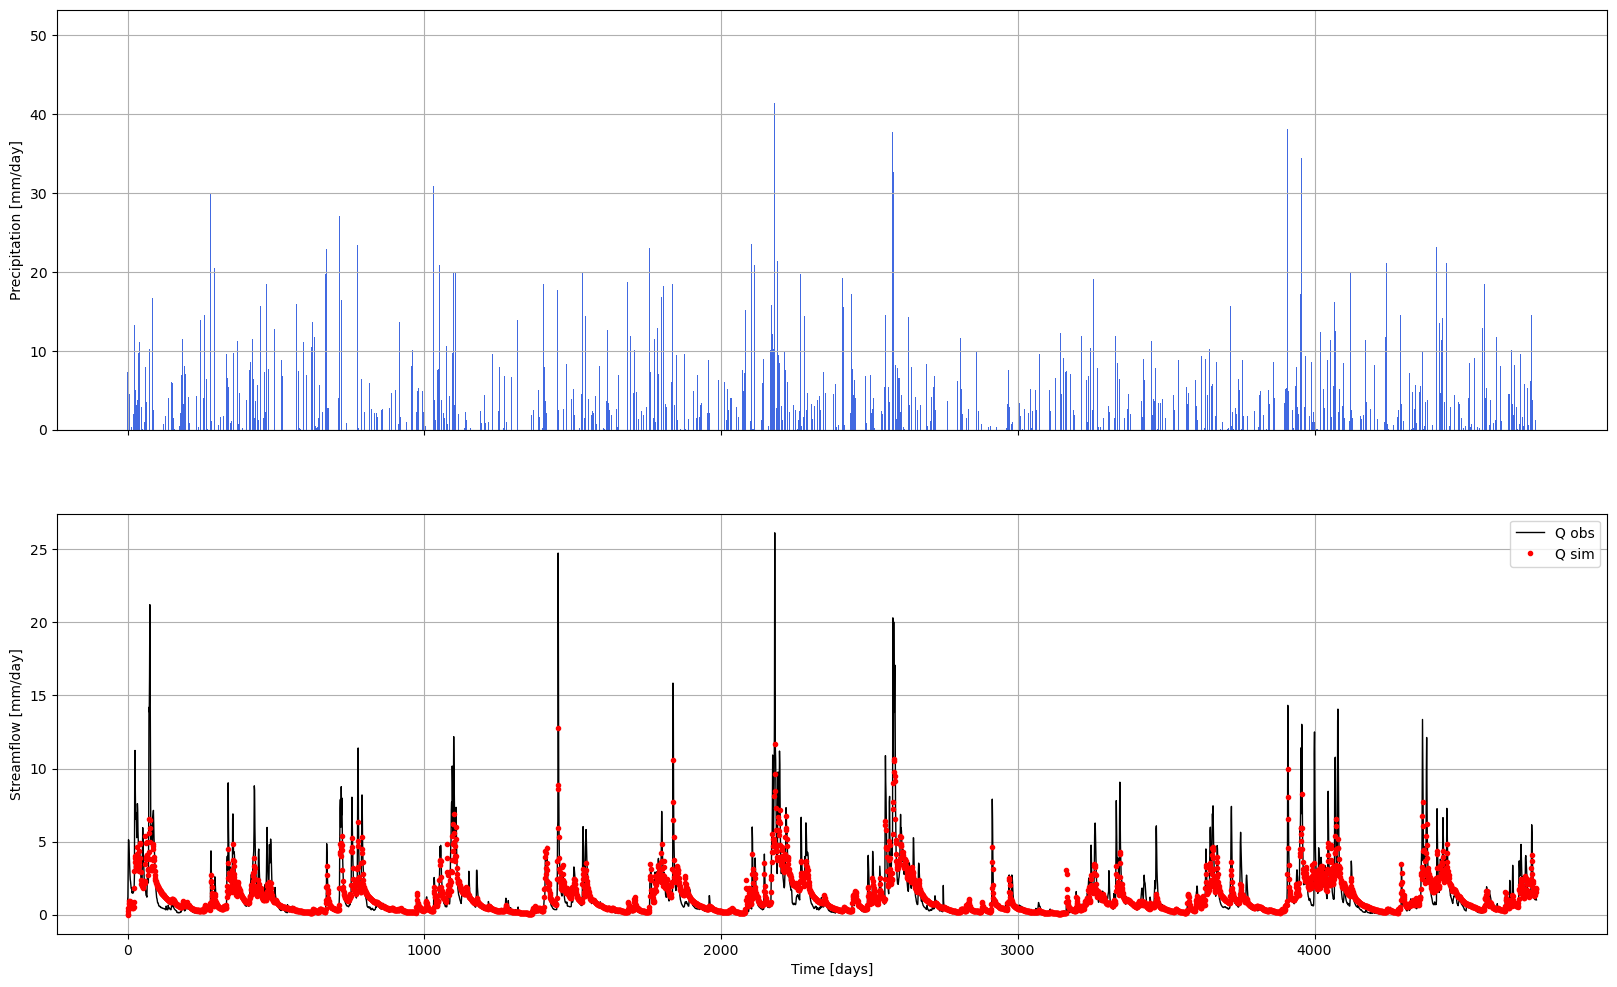

In [324]:
# Plot
fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [158]:
best_params_dict['M4_lowersplitter_split-par'] = 0.66
best_params_dict

{'M4_fast_k': 0.890489732915975,
 'M4_slow_k': 0.0959762039754239,
 'M4_unsaturated_Ce': 1.6866930895161638,
 'M4_unsaturated_m': 0.7382485901285071,
 'M4_unsaturated_beta': 4.142594857663019,
 'M4_lowersplitter_split-par': 0.66,
 'M4_lag-fun_lag-time': 3.984620364908275}

In [ ]:
hyd_mod.reset_states()
hyd_mod.set_input([P,E])
hyd_mod.set_timestep(1.0)
hyd_mod.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = hyd_mod.get_output()
output

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

In [ ]:
Qtimeseries = Qtimeseries.iloc[365:, :]

In [ ]:
1 - obj_fun_nsee(observations = Qtimeseries.loc[:, "Qobs"], simulation = Qtimeseries.loc[:,"Qcalc"], expo = 0.5)

In [ ]:
Qtimeseries.plot()

In [ ]:
Qtimeseries_mon = Qtimeseries.resample('M').agg(lambda x: np.nan if np.isnan(x).any() else np.mean(x))
Qtimeseries_mon

In [ ]:
1 - obj_fun_nsee(observations = Qtimeseries_mon.loc["1995":"2005", "Qobs"], simulation = Qtimeseries_mon.loc["1995":"2005","Qcalc"], expo = 0.5)

In [ ]:
Qtimeseries_mon.plot()

# Data with snow reservoir

In [528]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

#root_finder = PegasusPython()
#num_app = ImplicitEulerPython(root_finder=root_finder)

root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'split-par']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter2 = ParameterizedSingleFluxSplitter(
    parameters={'split-par': 0.6},
    id='lowersplitter'
)


# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 50.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

hyd_mod = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter2],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='M4'
)

hyd_mod

Module: superflexPy
Unit: M4
Layers:
	[['upper-splitter'], ['snow', 'upper-transparent'], ['upper-junction'], ['unsaturated'], ['lowersplitter'], ['slow', 'lag-fun'], ['lower-transparent', 'fast'], ['lower-junction']]
********************
Module: superflexPy
Element: upper-splitter
Weight:
	[[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
Direction:
	[[0, 1, None], [2, None, None]]

********************
Module: superflexPy
Element: snow
Parameters:
	M4_snow_t0 : 0.0
	M4_snow_k : 0.01
	M4_snow_m : 2.0
States:
	M4_snow_S0 : 0.0

********************
Module: superflexPy
Element: upper-transparent

********************
Module: superflexPy
Element: upper-junction
Direction:
	[[0, None], [None, 0]]

********************
Module: superflexPy
Element: unsaturated
Parameters:
	M4_unsaturated_Smax : 50.0
	M4_unsaturated_Ce : 1.0
	M4_unsaturated_m : 0.01
	M4_unsaturated_beta : 2.0
States:
	M4_unsaturated_S0 : 10.0

********************
Module: superflexPy
Element: lowersplitter
Parameters:
	M4_lowersplitter_spl

In [529]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):
        #obj_fun = spotpy.objectivefunctions.rmse(evaluation=evaluation,
        #                                                  simulation=simulation)
        #obj_fun = np.sum(np.sqrt(((simulation - evaluation)**2)/100))
        #obj_fun = obj_fun_nsee(observations = evaluation, simulation = simulation, expo = 0.5)
        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        #obj_fun = obj_fun_kge(observations = evaluation_used, simulation = simulation_used)

        
        return obj_fun

In [530]:
hyd_mod.reset_states()

spotpy_hyd_mod = spotpy_model(
    model=hyd_mod,
    inputs=[P, T, E],
    dt=1.0,
    observations = Q_obs,
    parameters=[
        spotpy.parameter.Uniform('M4_fast_k', 1e-5, 1.0), #1e-3, 0.5
        #spotpy.parameter.Uniform('M4_fast_alpha', 1.0, 2.0),
        spotpy.parameter.Uniform('M4_slow_k ', 1e-8, 0.1), #0.0001, 1.0
        #spotpy.parameter.Uniform('M4_slow_alpha ', 1, 2),
        #spotpy.parameter.Uniform('M4_unsaturated_Smax', 50, 600), #
        
        spotpy.parameter.Uniform('M4_unsaturated_Ce', 0.1, 3.0),#0.5, 4.0
        spotpy.parameter.Uniform('M4_unsaturated_m', 0.01, 1.0),
        spotpy.parameter.Uniform('M4_unsaturated_beta', 0.1, 10.0),#1.0, 4.0
        spotpy.parameter.Uniform('M4_lowersplitter_split-par', 0.5, 0.9),
        spotpy.parameter.Uniform('M4_lag-fun_lag-time', 1.0, 4.0),
        #spotpy.parameter.Uniform('M4_snow_k', 0.0, 1.0),

    ],
    #parameter_names=['model_FR1_k', 'model_FR1_alpha', 'model_FR1_Ce'],
    parameter_names=['M4_fast_k', 'M4_slow_k', 'M4_unsaturated_Ce', 'M4_unsaturated_m', 'M4_unsaturated_beta',
                     'M4_lowersplitter_split-par', 'M4_lag-fun_lag-time'], #"M4_snow_k"
    output_index=0
)

In [531]:
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler.sample(repetitions=500)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  500  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
29 of 500, minimal objective function=0.351033, time remaining: 00:00:32
58 of 500, minimal objective function=0.351033, time remaining: 00:00:30
93 of 500, minimal objective function=0.297918, time remaining: 00:00:26
130 of 500, minimal objective function=0.297918, time remaining: 00:00:23
169 of 500, minimal objective function=0.297918, time remaining: 00:00:20
207 of 500, minimal objective function=0.297918, time remaining: 00:00:17
246 of 500, minimal objective function=0.297918, time remaining: 00:00:15
283 of 500, minimal objective function=0.297918, time remaining: 00:00:12
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
354 of 500, minimal objective function=0.297918, time remaining: 00:00:08
452 of 500, 

The figure as been saved as "Parameter_trace.png
Run number 84 has the lowest objectivefunction with: 0.2979


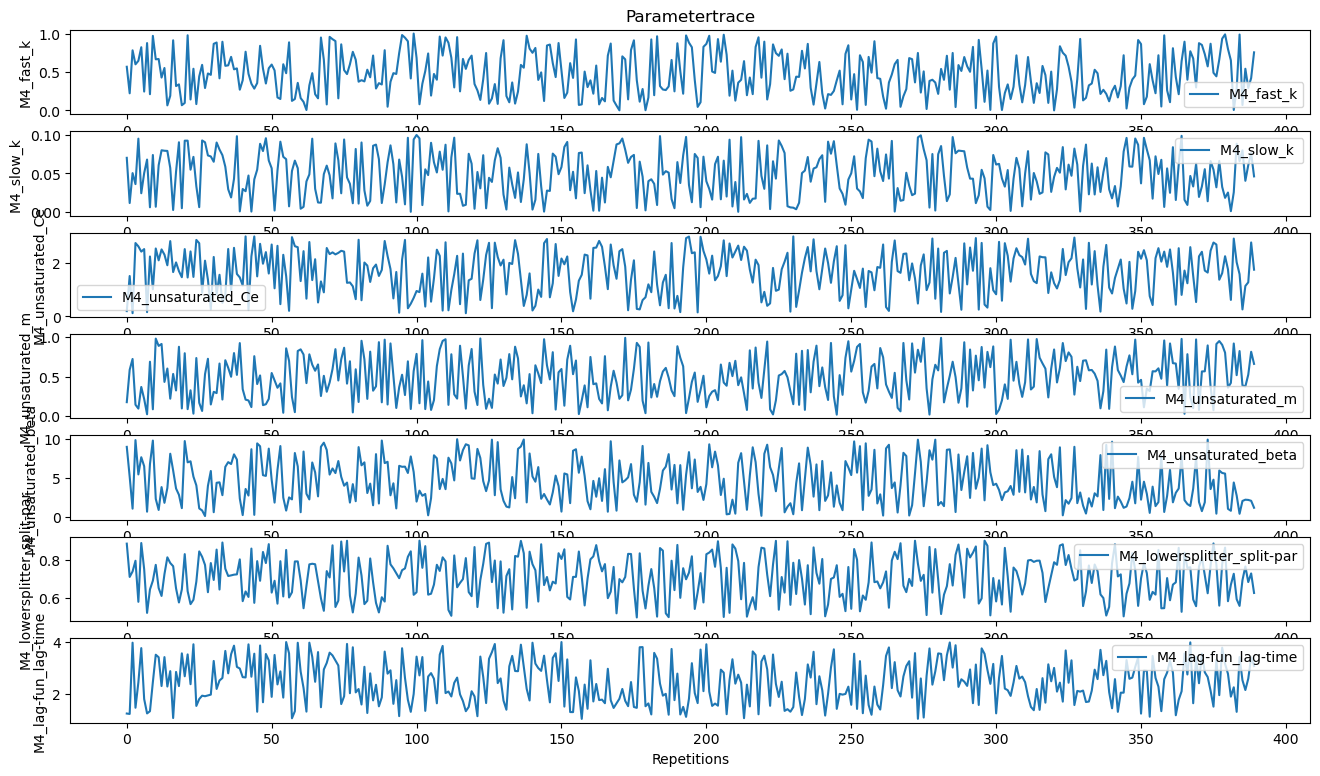

In [532]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function

spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')

# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])

In [533]:
best_model_run

(0.29791833, 0.43108963, 0.01454814, 1.28398747, 0.81752949, 4.28031849, 0.80619576, 2.78372505, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.00011584, 0.00070681, 0.00074797, 0.00086273, 0.0028003, 0.01440365, 0.02969698, 0.08901418, 0.47386362, 1.08960517, 1.53654787, 0.86042825, 0.5806651, 0.46946824, 0.41745964, 0.3660228, 0.3251263, 0.35565831, 0.40379247, 0.50053157, 0.51721995, 0.88704981, 1.47014291, 1.97410869, 1.45547381, 1.25234979, 1.4384216, 1.6054544, 1.28220249, 0.96987826, 0.84133907, 1.06383384, 2.27941481, 3.97497656, 4.41985889, 3.11214, 3.46220828, 3.9378335, 4.19519482, 4.70257823, 4.46475726, 3.72475673, 2.91467447, 2.5616937, 2.31209383, 2.08506231, 1.98694321, 1.93302913, 1.89728192, 1.83121642, 1.7811822, 1.74019553, 1.70473897, 1.67287701, 1.6574196, 1.64086589, 1.62723499, 1.59478315, 1.79263554, 2.95188208, 4.89989046, 5.64839613, 4.06638417, 3.51657338, 2.97726333, 2.50510381, 2.29282919, 2.17423282, 2.09620199, 2.03823011, 1.99

In [534]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = best_simulation[365:], expo = 0.5)

0.7023526774726423

In [535]:
1 - obj_fun_kge(observations = Q_obs[365:], simulation = best_simulation[365:])

0.6002800916208626

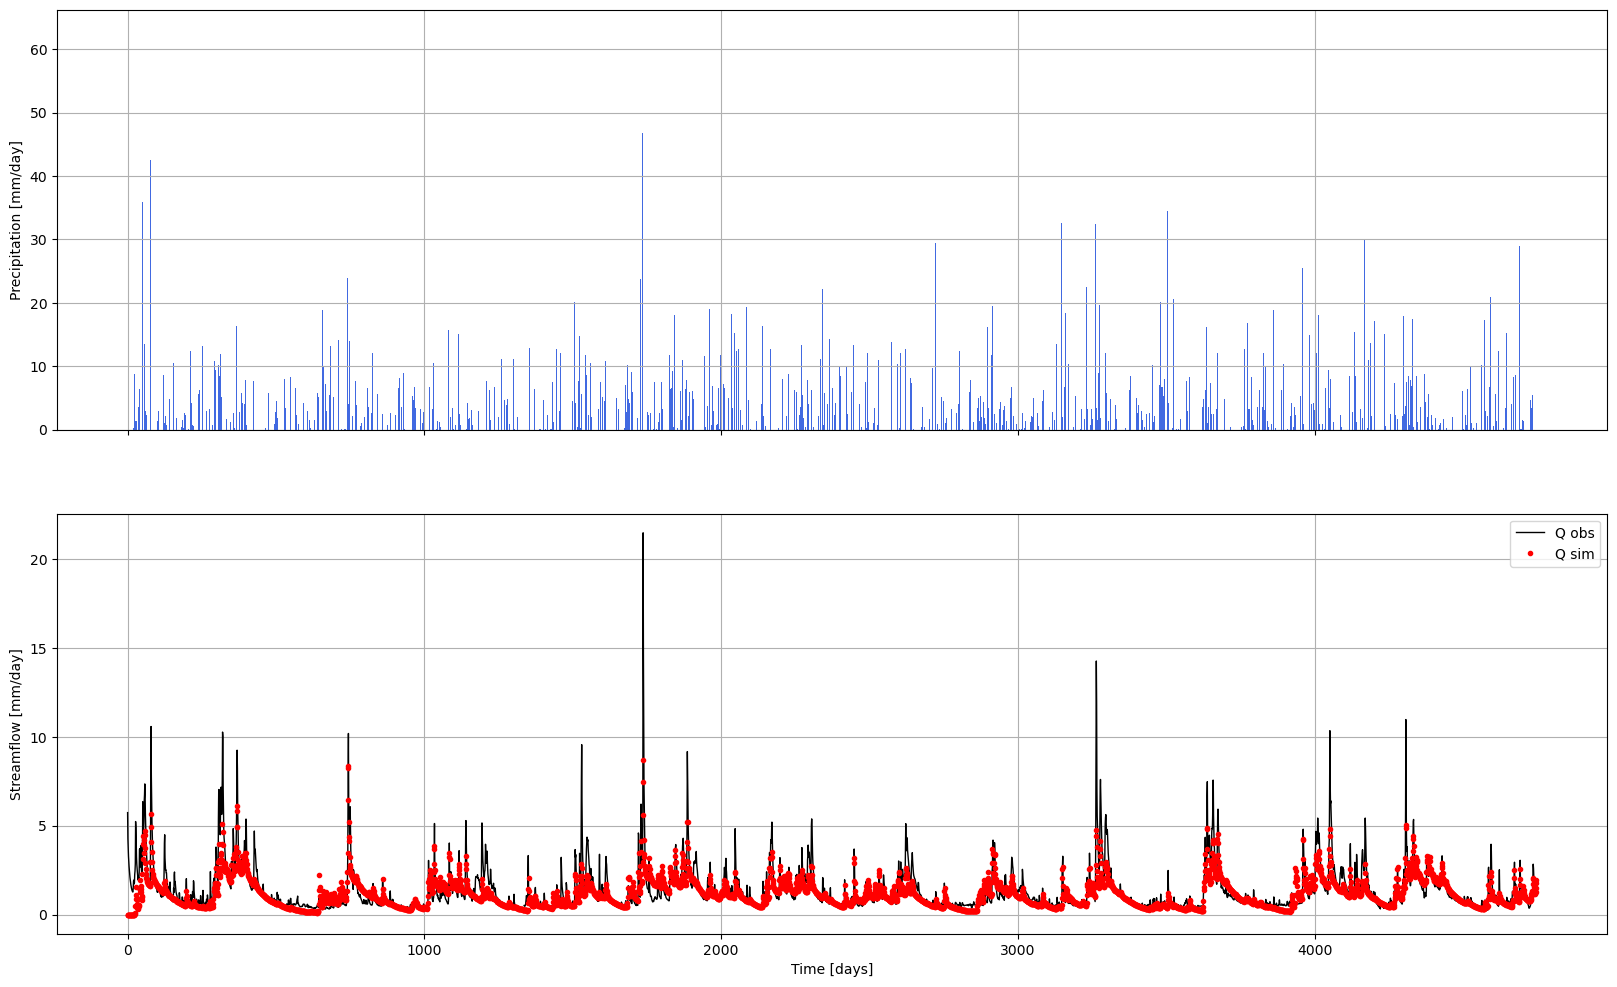

In [536]:
# Plot
fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [537]:
best_params_dict

{'M4_fast_k': 0.43108963281902846,
 'M4_slow_k': 0.014548136605651577,
 'M4_unsaturated_Ce': 1.2839874702371687,
 'M4_unsaturated_m': 0.8175294867738179,
 'M4_unsaturated_beta': 4.2803184944406025,
 'M4_lowersplitter_split-par': 0.8061957610000936,
 'M4_lag-fun_lag-time': 2.783725045167527}

In [335]:
best_params_dict['M4_lowersplitter_split-par'] = 0.5
#best_params_dict['M4_fast_k'] = 2.0
#best_params_dict['M4_slow_k'] = 0.01
#best_params_dict['M4_snow_k'] = 0.01
#best_params_dict['M4_lag-fun_lag-time'] = 3.0
#best_params_dict['M4_unsaturated_beta'] = 5.0

In [539]:
hyd_mod.reset_states()
hyd_mod.set_input([P,T, E])
hyd_mod.set_timestep(1.0)
hyd_mod.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = hyd_mod.get_output()
output

[array([0.        , 0.        , 0.        , ..., 1.95174625, 1.47808236,
        1.27529943])]

In [548]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

,Qobs,Qcalc
2002-01-01,5.734149,0.000000
2002-01-02,4.261444,0.000000
2002-01-03,3.666095,0.000000
2002-01-04,3.274419,0.000000
2002-01-05,2.961077,0.000000
...,...,...
2014-12-27,1.629376,1.427354
2014-12-28,2.005386,1.759314
2014-12-29,1.621542,1.951746
2014-12-30,1.378703,1.478082


In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2001', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

ValueError: Length of values (4748) does not match length of index (5113)

In [549]:
data_comparation = Qtimeseries.copy()

data_comparation

,Qobs,Qcalc
2002-01-01,5.734149,0.000000
2002-01-02,4.261444,0.000000
2002-01-03,3.666095,0.000000
2002-01-04,3.274419,0.000000
2002-01-05,2.961077,0.000000
...,...,...
2014-12-27,1.629376,1.427354
2014-12-28,2.005386,1.759314
2014-12-29,1.621542,1.951746
2014-12-30,1.378703,1.478082


ValueError: zero-size array to reduction operation fmin which has no identity

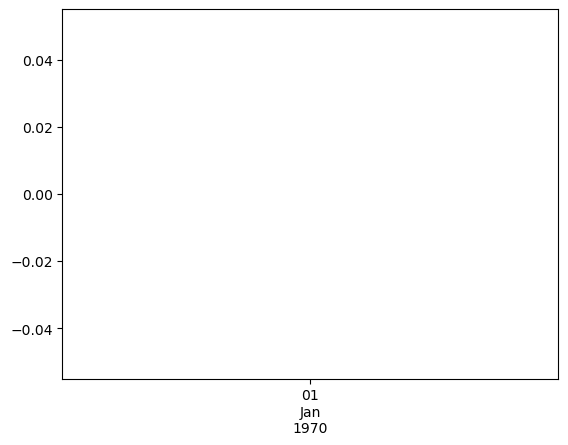

In [550]:
data_comparation.loc["1995-02-01":"1995-06-01"].plot()

<Axes: >

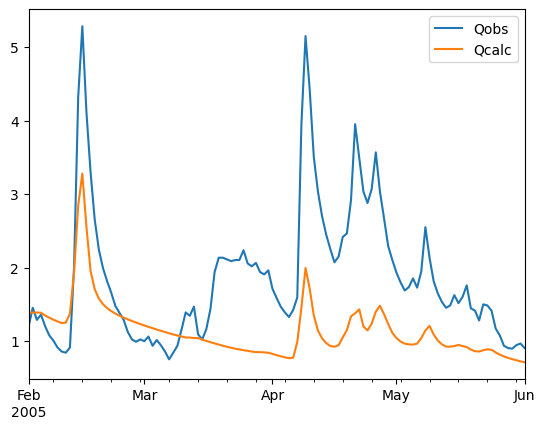

In [551]:
data_comparation.loc["2005-02-01":"2005-06-01"].plot()

In [552]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7023526774726423

In [553]:
network_estreams.loc[basin_id, :]

gauge_id                                                      A634101001
gauge_name                                      La Meurthe Ã  LunÃ©ville
gauge_country                                                         FR
gauge_provider                                              FR_EAUFRANCE
river                                             La Meurthe à Lunéville
lon_snap                                                        6.481033
lat_snap                                                       48.582851
lon                                                             6.481033
lat                                                            48.582851
elevation                                                            219
area_official                                                     1105.0
area_estreams                                                    1102.95
area_flag                                                              0
area_rel                                           